[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/image/facial-similarity-search/facial-similarity-search.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/image/facial-similarity-search/facial-similarity-search.ipynb)

# Facial Similarity Search with Pinecone

In this notebook, we will demonstrate how to use Pinecone to build an image-based vector search application to discover people with similar facial features. We will:

1. Extract faces from a celebrity image dataset
2. Convert the faces to embeddings and store them in a Pinecone index (alongside metadata related to the celebrities)
3. Query the Pinecone index with an image of a person and find the most similar celebrities


# Install Dependencies

In [ ]:
!pip install datasets pinecone-client[grpc] facenet-pytorch requests Pillow

# Load Dataset

We will use a dataset containing photos of ~115K most popular people on The Movie Database (TMDB). This dataset can be loaded from Huggingface as follows:

In [2]:
from datasets import load_dataset

# load the dataset
celeb_faces = load_dataset("ashraq/tmdb-people-image", split="train")
celeb_faces

Computing checksums:  44%|####4     | 4/9 [00:06<00:07,  1.54s/it]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/116404 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ashraq___parquet/ashraq--tmdb-people-image-e6aad5cbcdeb9255/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['adult', 'also_known_as', 'biography', 'birthday', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'name', 'place_of_birth', 'popularity', 'profile_path', 'image'],
    num_rows: 116404
})

We have got few metadata about the people and their image in the dataset. Let's take a look:

In [3]:
celeb = celeb_faces[10]
celeb

{'adult': False,
 'also_known_as': "['Thomas Stanley Holland', 'Том Холланд', 'トム・ホランド', '톰 홀랜드', 'توم هولاند', 'ทอม ฮอลแลนด์', '汤姆·赫兰德', 'Τομ Χόλαντ', 'Том Голланд', '湯姆·霍蘭德', 'טום הולנד', 'תומאס סטנלי הולנד', 'Nhện Đệ Tam', 'ტომ ჰოლანდი']",
 'biography': 'Thomas "Tom" Stanley Holland is an English actor and dancer. He is best known for playing Peter Parker / Spider-Man in the Marvel Cinematic Universe and has appeared as the character in six films: Captain America: Civil War (2016), Spider-Man: Homecoming (2017), Avengers: Infinity War (2018), Avengers: Endgame (2019), Spider-Man: Far From Home (2019), and Spider-Man: No Way Home (2021). He is also known for playing the title role in Billy Elliot the Musical at the Victoria Palace Theatre, London, as well as for starring in the 2012 film The Impossible.',
 'birthday': '1996-06-01',
 'deathday': None,
 'gender': 2,
 'homepage': None,
 'id': 1136406,
 'imdb_id': 'nm4043618',
 'known_for_department': 'Acting',
 'name': 'Tom Holland',
 '

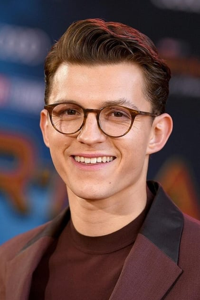

In [4]:
celeb["image"].resize((200, 300))

We do not need all these metadata fields. So we will remove the ones we do not need and convert the rest into a pandas dataframe.

In [5]:
# remove metadata fields not needed, convert into a pandas dataframe
metadata = celeb_faces.remove_columns(['adult', 'also_known_as', 'biography', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'image']).to_pandas()
# replace any empty fields with None
metadata = metadata.fillna("None")

# Embedding Model

We will use two models: one for extracting faces and another for generating vector embeddings of the face. We're focusing on faces only because using full images would introduce too much noise and result in poor results.

For face extraction, we will use MTCNN, which is a popular choice due to its ability to accurately detect and align faces in images despite variations in pose and appearance. We can use a Pytorch implementation of MTCNN with the ``facenet-pytorch`` package. Since the images in our dataset are already in PIL format, we can directly test the MTCNN model, which expects PIL image objects as inputs, as shown below:

In [6]:
from facenet_pytorch import MTCNN

# initialize the MTCNN model
mtcnn = MTCNN()
# create a copy of the face
img = celeb["image"].copy()
# detect face and get coordinates of the face with probability
boxes, prob = mtcnn.detect(img)
boxes, prob

(array([[ 91.4824  , 112.335335, 316.80338 , 409.37723 ]], dtype=float32),
 array([0.9999924], dtype=float32))

The detect method in MTCNN gives us the coordinates of the face and how confident it was in detecting the face, in this case, with 99% accuracy. Let's draw a rectangle on the image using these coordinates to see if it correctly detected the face.

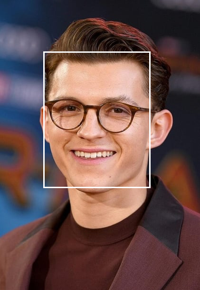

In [7]:
from PIL import Image, ImageDraw

# draw a rectangle on the image using coordinates returned by the MTCNN model
draw = ImageDraw.Draw(img)
draw.rectangle(boxes.reshape((2,2)), width=3)
# resize the image to display a smaller size
img.resize((200, 290))

As we can see, the model has successfully identified the face. To extract the face, we can crop the image to only include the area within the rectangle, using either ``opencv`` or another package. Alternatively, the ``facenet-pytorch`` package has a function that does this for us and returns the result as Pytorch tensors that can be used as input for the embedding model directly. This can be done as follows:

In [8]:
# pass the image or batch of images directly through mtcnn model
face = mtcnn(img)
face.shape

torch.Size([3, 160, 160])

To generate embeddings, we will use VGGFace2, which is a deep learning model for facial recognition that was trained on the VGGFace2 dataset, which includes more than 3 million images of over 9000 people. The model can be loaded and used as follows:

In [9]:
from facenet_pytorch import InceptionResnetV1
import torch

# initialize VGGFace2 model
resnet = InceptionResnetV1(pretrained="vggface2").eval()
# generate embedding for the face extracted using mtcnn above
embedding = resnet(torch.stack([face]))
embedding.shape

  0%|          | 0.00/107M [00:00<?, ?B/s]

torch.Size([1, 512])

We can now generated vector embedding for the face. Let's write a pipeline to easy do all of this in batches.

In [10]:
import numpy as np


class FacenetEmbedder:
    def __init__(self):
        # set device to use GPU if available
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        # initialize MTCNN model
        self.mtcnn = MTCNN(device=self.device)
        # initialize VGGFace2 model
        self.resnet = InceptionResnetV1(pretrained='vggface2', device=self.device).eval()

    def detect_face(self, batch):
        # get coordinates of the face
        faces = self.mtcnn.detect(batch)
        return faces

    def encode(self, batch):
        # pass the batch of images directly through mtcnn model
        face_batch = self.mtcnn(batch)
        # remove any images that does not contain a face
        face_batch = [i for i in face_batch if i is not None]
        # concatenate face batch to form a single tensor
        aligned = torch.stack(face_batch)
        # if using gpu move the input batch to gpu
        if self.device.type == "cuda": 
            aligned = aligned.to(self.device)
        # generate embedding
        embeddings = self.resnet(aligned).detach().cpu()
        return embeddings.tolist()

In [11]:
# initialize the embedding pipeline
facenet = FacenetEmbedder()

In [12]:
# test the pipeline using a small image batch
batch = celeb_faces[10:20]["image"]
len(facenet.encode(batch))

10

We can now simply call the ``encode`` method in the ``FacenetEmbedder`` with a batch of PIL images and it would extract the faces and generate embedding for us. Keep in mind that batch encoding only works if all the images in the batch have the same shape. We can use the following function to reshape a batch of PIL images to ensure it always works.

In [13]:
def reshape(batch):
    batch = [image.convert("RGB").resize((421, 632)) for image in batch]
    return batch

# Initialize Pinecone Index

Now we need to set up the Pinecone index, which stores vector representations of our images that can be retrieved using the embedding of another image (called the query vector). Before we can do this, we have to establish a connection to Pinecone using an API key. You can find your environment in the [Pinecone console](https://app.pinecone.io) under **API Keys**. This connection is initialized as follows:

In [14]:
import pinecone

# connect to pinecone environment
pinecone.init(
    api_key="YOUR_API_KEY",
    environment="YOUR_ENV"  # find next to API key in console
)

Now, we can create our vector index and name it "tmdb-people" (although you can choose any name you like). We specify the metric type as cosine and the dimension as 512, as these are the vector space and dimensionality of the vectors produced by the embedding model we use.

In [15]:
index_name = "tmdb-people"

# check if the tmdb-people index exists
if index_name not in pinecone.list_indexes():
    # create the index if it does not exist
    pinecone.create_index(
        index_name,
        dimension=512,
        metric="cosine"
    )

# connect to tmdb-people index we created
index = pinecone.GRPCIndex(index_name)

# Generate Embeddings and Upsert

Next, we need to generate embeddings for the celebrity faces and upload them into the Pinecone index. To do this efficiently, we will process them in batches and upload the resulting embeddings to the Pinecone index. For each celebrity in the dataset, we need to provide Pinecone with a unique id, the corresponding embedding, and metadata. The metadata is a collection of information related to the celebrities, including their name, profile image url, date of birth, etc.

In [ ]:
from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(celeb_faces), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(celeb_faces))
    # extract batch
    batch = celeb_faces[i:i_end]["image"]
    # reshape the images to ensure they all have same shape
    batch = reshape(batch)
    # generate embeddings for batch
    emb = facenet.encode(batch)
    # create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # add metadata
    meta = metadata[i:i_end].to_dict(orient="records")
    # add all to upsert list
    to_upsert = list(zip(ids, emb, meta))
    # upsert/insert these records to pinecone
    _ = index.upsert(vectors=to_upsert)

# # check that we have all vectors in index
index.describe_index_stats()

We have successfully added everything we need to the Pinecone index.

# Find Similar Celebrities

Now we can query the Pinecone index with an embedding of a face and instantly get the celebrities that are most similar. First, let's write a helper functions to query pinecone and display the results.

In [16]:
from IPython.core.display import HTML


def display_result(metadata):
    figures = []
    for m in metadata:
        figures.append(f'''
            <figure style="margin: 5px !important;">
                <img src="https://image.tmdb.org/t/p/h632/{m["profile_path"]}" style="width: 190px; height: 240px; border-radius: 10px;" >
                <figcaption>{m["name"]}</figcaption>
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [17]:
def find_similar_faces(face, top_k=10):
    # pass the image through the embedding pipeline
    emb = facenet.encode([face])
    # query pinecone with the face embedding
    result = index.query(emb[0], top_k=6, include_metadata=True)
    # extract metadata from the search results and display results 
    r = [x["metadata"] for x in result["matches"]]
    return display_result(r)

Let's run some test queries using celebrity images from the dataset to find other celebrities who look alike.

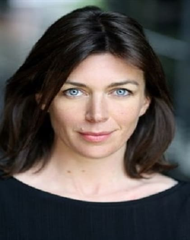

In [19]:
celeb = celeb_faces[40]["image"]
celeb.resize((190,240))

In [20]:
find_similar_faces(celeb)

The search result looks good as we can definately see some celebrities with similar facial features. Let's run more queries.

In [21]:
celeb = celeb_faces[35]["image"]
find_similar_faces(celeb)

In [22]:
celeb = celeb_faces[1]["image"]
find_similar_faces(celeb)

In [23]:
celeb = celeb_faces[12]["image"]
find_similar_faces(celeb)

In [24]:
celeb = celeb_faces[17]["image"]
find_similar_faces(celeb)

In [25]:
celeb = celeb_faces[29]["image"]
find_similar_faces(celeb)

In [26]:
celeb = celeb_faces[64]["image"]
find_similar_faces(celeb)

The search results look excellent. To further test our system, let's try using images that are not in the dataset. The following function, ``get_image``, can be utilized to load an image as a PIL object using a URL:

In [28]:
from PIL import Image
import requests

def get_image(url):
  img = Image.open(requests.get(url, stream=True).raw)
  return img
  

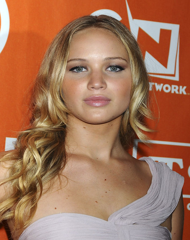

In [41]:
url = "https://live.staticflickr.com/7442/9509564504_21d2dc42e1_z.jpg"
# load the image as PIL object from url
celeb = get_image(url)
celeb.resize((190,240))

In [42]:
find_similar_faces(celeb)

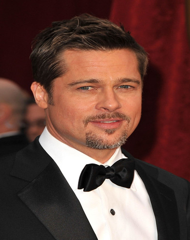

In [50]:
url = "https://live.staticflickr.com/3563/3304692615_bc67db2606_z.jpg"
# load the image as PIL object from url
celeb = get_image(url)
celeb.resize((190,240))

In [51]:
find_similar_faces(celeb)

As we can see, the search result correctly identifies the celebrity in the picture as the top match and also finds other celebrities with similar facial features.

# Example Application

Are you curious if you share a resemblance with a famous celebrity? Try this [demo app](https://huggingface.co/spaces/pinecone/find-your-celebrity-match), which has been built based on this notebook, to find out.